<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting WT vs p.Glu50fs*3 LCMS lipidomics results

<strong>Input Data:</strong>

`1096.SUB12877_lipidXData.csv` 


<strong>Figures:</strong>

`ED11`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()

In [2]:
# load libraries
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation


load the data

In [3]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '1096.SUB12877_lipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 

sample_dictionary = {'s1':'WT',
                     's2':'G2',
                     's3':'WT',
                     's4':'G2',
                     's5':'G2+choline'}

lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

Compute stats

In [4]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT', 'G2')

stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['p_value'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)
print(stats.shape)

stats.head()

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


(447, 11)


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,name,grp,class,carbons,unsaturations,unsat_grp,cat
Cer(d15:0_26:2)-H_47.3,-1.833421,0.097373,-0.612545,0.210539,Cer(d15:0_26:2)-H_47.3,Sphingolipids,Cer,41,2,PUFA,other
Cer(d17:1_16:0)-H_42.85,-0.659965,0.524282,-0.242076,0.602452,Cer(d17:1_16:0)-H_42.85,Sphingolipids,Cer,33,1,MUFA,other
Cer(d18:0_16:0)+H_35.41,0.864029,0.412678,0.256591,0.494550,Cer(d18:0_16:0)+H_35.41,Sphingolipids,Cer,34,0,SFA,other
Cer(d18:0_18:0)+H_44.03,3.136402,0.017029,2.109618,0.060413,Cer(d18:0_18:0)+H_44.03,Sphingolipids,Cer,36,0,SFA,other
Cer(d18:0_18:0)-H_45.32,2.865600,0.020442,0.817624,0.069222,Cer(d18:0_18:0)-H_45.32,Sphingolipids,Cer,36,0,SFA,other


Save stats

In [5]:
stats.to_csv('../../../extended_tables/lcms_G2.csv')

Remove ambiguous lipids 

In [6]:
import re

def is_x1_y1_format(lipid_annotation):
    # Extract the part inside the parentheses.
    match = re.search(r'\(([^)]*)\)', lipid_annotation)
    if not match:
        return False
    chains_str = match.group(1)
    
    # Split the string into two fatty acid chains
    parts = chains_str.split('_')
    if len(parts) != 2:
        return False
    
    # Define regex for a fatty acid in the format: optional letters, digits, colon, and exactly '1'
    pattern = re.compile(r'^[a-zA-Z]*\d+:1$')
    
    # Check if both parts match the expected x:1 format.
    return all(pattern.match(part) for part in parts)

def count_unsaturations(lipid_name):
    """
    Count the total number of unsaturated bonds in a lipid species name.
    The function extracts the substring within parentheses and finds all occurrences
    of a pattern where a colon is followed by a number (e.g., '10:1').
    It returns the sum of these numbers.
    """
    # Extract the content inside parentheses
    m = re.search(r'\((.*?)\)', lipid_name)
    if m:
        inside = m.group(1)
        # Find all numbers that follow a colon (e.g., in "10:1", captures "1")
        unsat_numbers = re.findall(r':(\d+)', inside)
        if unsat_numbers:
            return sum(int(num) for num in unsat_numbers)
    # Return 0 if no unsaturation information is found
    return 0

def is_ambiguous_lipid(lipid_annotation):
    """
    Returns True if the lipid annotation is ambiguous.
    A lipid is considered ambiguous if:
      - Its fatty acyl chains are provided as a sum composition (i.e. no underscore in the parentheses), AND
      - The double bond count in that sum composition is exactly 2 (e.g., "20:2").
    
    Examples:
      - "ZyE(20:2)+H_52.77" returns True.
      - "ZyE(20:3)+H_52.77" returns False (because the double bond count is not 2).
      - "PC(19:1_18:1)+HCOO_45.79" returns False (because two chains are specified).
    """
    # Extract the substring inside the parentheses
    match = re.search(r'\(([^)]*)\)', lipid_annotation)
    if not match:
        return False
    acyl_str = match.group(1)
    
    # If an underscore is present, it means the fatty acids are given as separate chains (unambiguous)
    if '_' in acyl_str:
        return False

    # Check if the acyl chain follows the x:2 format (with optional letter prefixes)
    pattern = re.compile(r'^[a-zA-Z]*\d+:2$')
    return bool(pattern.match(acyl_str))

# Example usages:
print(is_ambiguous_lipid("ZyE(20:2)+H_52.77"))      # Expected output: True
print(is_ambiguous_lipid("ZyE(20:3)+H_52.77"))      # Expected output: False
print(is_ambiguous_lipid("PC(19:1_18:4)+HCOO_45.79")) # Expected output: False
print(is_ambiguous_lipid("Lipid(17:2)+H"))            # Expected output: True
print(is_ambiguous_lipid("Lipid(17:1)+H"))            # Expected output: False

True
False
False
True
False


In [7]:

# Example usages:
print(is_x1_y1_format("PC(19:1_18:1)+HCOO_45.79"))  # Expected output: True
print(is_x1_y1_format("PC(19:1_18:1)")) 


True
True


In [8]:
x = stats[stats['class'] == 'PC']
x[(x['fdr_corrected_p_value'] < 0.05) & (x['log2_fold_change'] < -1)].shape

(10, 11)

In [9]:
# update unsaturation group for missed MUFA 
stats['is_missed_mufa'] = stats['name'].apply(is_x1_y1_format)
stats['is_ambiguous_lipid'] = stats['name'].apply(is_ambiguous_lipid)
stats.loc[stats['is_missed_mufa'],'unsat_grp'] = 'MUFA'
stats = stats[np.invert(stats['is_ambiguous_lipid'])]

Plot PCs

KeyboardInterrupt: 

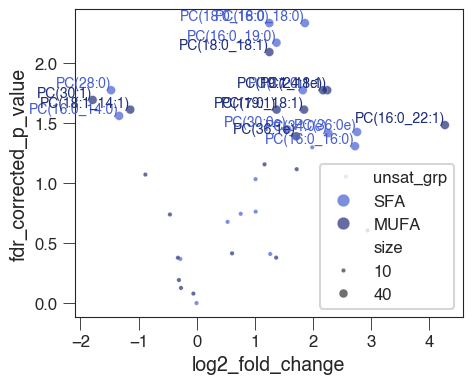

In [10]:

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-2,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-1.1, .1, 'Down in \np.Glu50fs*3', ha='center', fontsize=10)

#plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             #arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
#plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/G2_PC_volcano_sat.pdf', dpi=300, bbox_inches='tight')



Show unsaturated species

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


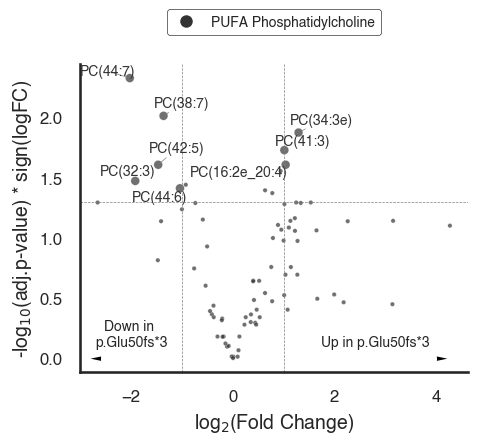

In [11]:
subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=5, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-3,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2, .1, 'Down in \np.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/G2_PC_volcano_unsat.pdf', dpi=300, bbox_inches='tight')



plot TGs

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


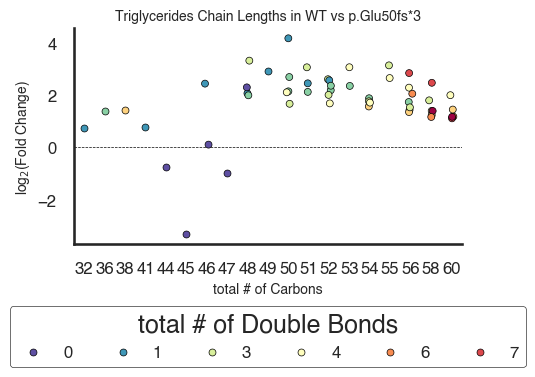

In [12]:
temp = stats[stats['class']=='TG'].copy()
temp['score'] = np.sign(temp['log2_fold_change']) * -np.log10(temp['fdr_corrected_p_value'])
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/tg_carbons.pdf', dpi=300, bbox_inches='tight')


Plot PCs

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


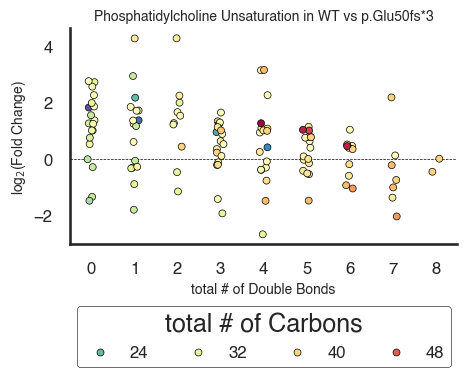

In [13]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/pc_unsat.pdf', dpi=300, bbox_inches='tight')


Plot volcano 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


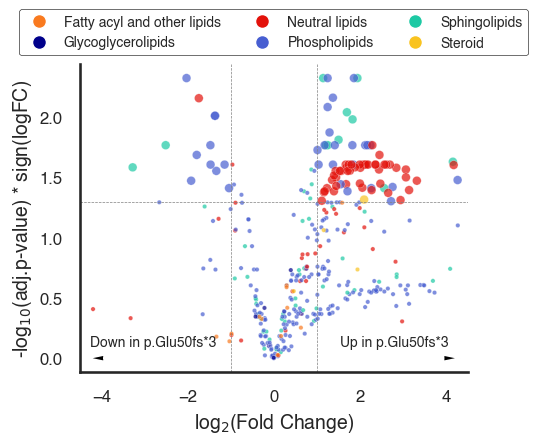

In [14]:
# plot volcano by major class
plot_volcano('fdr_corrected_p_value', 'name', 'grp', 'log2_fold_change',stats, lipid_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True, label_top_genes=False)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = np.unique(stats['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats['grp'])]]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/iN_lipids_overview.pdf', dpi=300, bbox_inches='tight')



Plot table

In [15]:
# get # of perturbed lipids per subclass

subclass_dict = dict(zip(key['Key'], key['subclass']))
grouped = stats.groupby('class')['cat'].value_counts().unstack(fill_value=0)

# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) + grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']

# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)

# subset table to only include classes with more than 0 total
table_df.sort_values(by='Total', ascending=False, inplace=True)
table_df = table_df.loc[table_df['Total']>0].copy()

# add subclass
table_df['Subclass'] = [subclass_dict[x] for x in table_df.index]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


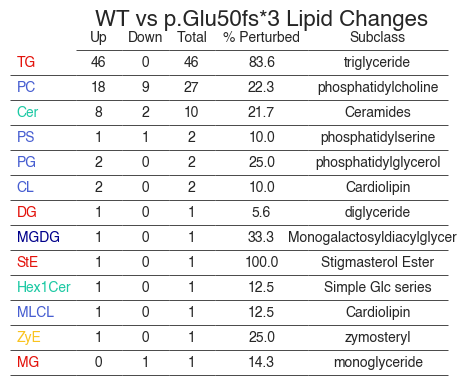

In [16]:
# plot the table 

table_palette = dict(zip(table_df.index, [lipid_palette[dictionary[x]] for x in table_df.index]))

fig, ax = plt.subplots(figsize=(3,2))
ax.axis('off')  # Hide the main axes

tbl = ax.table(cellText=table_df.values,
               rowLabels=table_df.index,
               colLabels=table_df.columns,
               cellLoc='center',
               loc='center', colWidths=[0.2, 0.2, 0.2, 0.4, 0.6])

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Color the row labels according to the palette.
# Matplotlib stores row labels in cells with (row, col) where col == -1.
for (row, col), cell in tbl.get_celld().items():
    if col == 0 and row > 0:  # row>0: skip header row label cell
        lipid_class = table_df.index[row-1]  # row labels start at row 1 in the table cells
        cell.set_facecolor(table_palette.get(lipid_class, 'blue'))

for key, cell in tbl.get_celld().items():
    
        cell.set_edgecolor('white')

for (row, col), cell in tbl.get_celld().items():
    if row > 0:  # for all cells in data rows
        # Show only the bottom edge:
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    else:
        # For header row, you can keep the default (or set a full box if desired)
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    if col == -1 and row > 0:  # skip header label cell if present
        lipid_class = table_df.index[row-1]  # adjust index for header offset
        cell.get_text().set_color(table_palette.get(lipid_class, 'black'))
plt.title('WT vs p.Glu50fs*3 Lipid Changes', fontweight="bold", pad=70)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/lipids_table.pdf', dpi=300, bbox_inches='tight')


Compute enrichment pvalues

In [17]:
S = stats

In [18]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

mufa_up_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['up'], 
                      S[(S['unsat_grp']=='MUFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='MUFA')&(S['class']=='PC') & (S['cat']=='up')].shape[0])

mufa_down_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['down'], 
                      S[(S['unsat_grp']=='MUFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='MUFA')&(S['class']=='PC') & (S['cat']=='down')].shape[0])

print('MUFA up p-value: ', mufa_up_pval)
print('MUFA down p-value: ', mufa_down_pval)


sfa_up_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['up'], 
                      S[(S['unsat_grp']=='SFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='SFA')&(S['class']=='PC') & (S['cat']=='up')].shape[0])

sfa_down_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['down'], 
                      S[(S['unsat_grp']=='SFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='SFA')&(S['class']=='PC') & (S['cat']=='down')].shape[0])

print('SFA up p-value: ', sfa_up_pval)
print('SFA down p-value: ', sfa_down_pval)

pufa_up_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['up'], 
                      S[(S['unsat_grp']=='PUFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='PUFA')&(S['class']=='PC') & (S['cat']=='up')].shape[0])

pufa_down_pval = get_hypergeom_p_value(S.shape[0], S['cat'].value_counts()['down'], 
                      S[(S['unsat_grp']=='PUFA')&(S['class']=='PC')].shape[0], 
                      S[(S['unsat_grp']=='PUFA')&(S['class']=='PC') & (S['cat']=='down')].shape[0])

print('PUFA up p-value: ', pufa_up_pval)
print('PUFA down p-value: ', pufa_down_pval)


MUFA up p-value:  0.09455823410340004
MUFA down p-value:  0.1316538645338267
SFA up p-value:  0.025744966508852486
SFA down p-value:  0.1212028805053486
PUFA up p-value:  0.9999989550873379
PUFA down p-value:  0.07817514686465181


In [19]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']=='MUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='MUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

mufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']=='MUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='MUFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('SFA/MUFA up p-value: ', mufa_up_pval)
print('SFA/MUFA down p-value: ', mufa_down_pval)


sfa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

sfa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('SFA up p-value: ', sfa_up_pval)
print('SFA down p-value: ', sfa_down_pval)

pufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

pufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('PUFA up p-value: ', pufa_up_pval)
print('PUFA down p-value: ', pufa_down_pval)


SFA/MUFA up p-value:  0.09455823410340004
SFA/MUFA down p-value:  0.1316538645338267
SFA up p-value:  0.025744966508852486
SFA down p-value:  0.1212028805053486
PUFA up p-value:  0.9999989550873379
PUFA down p-value:  0.07817514686465181
